<a href="https://colab.research.google.com/github/ASEM000/PyTreeClass/blob/main/assets/benchmark_flatten_unflatten.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install jax==0.4.6
!pip install jaxlib==0.4.6
!pip install flax
!pip install equinox
!pip install git+https://github.com/ASEM000/PyTreeClass

### Benchmark `flatten`/`unflatten`

12.3 µs ± 4.34 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
21 µs ± 6.84 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)
15.9 µs ± 4.88 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)
40.3 µs ± 7.33 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
388 µs ± 60.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
94.7 µs ± 27.2 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
392 µs ± 97.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
9.86 ms ± 437 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
931 µs ± 277 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


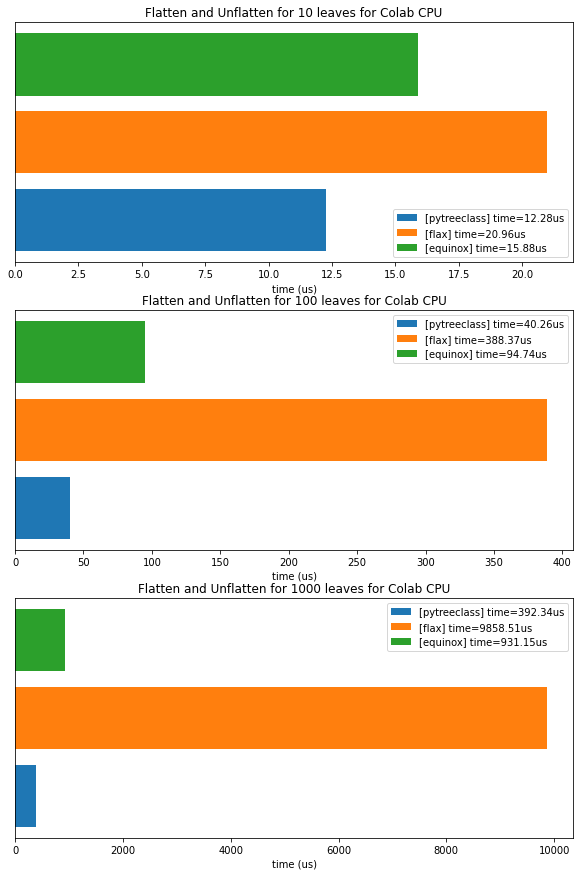

In [5]:
import string 
import random
import dataclasses as dc
import equinox as eqx
import flax 
import pytreeclass as pytc
import jax.tree_util as jtu
import matplotlib.pyplot as plt

def tree_copy(tree):
    leaves,treedef = jtu.tree_flatten(tree)
    return treedef.unflatten(leaves)

def random_string(length):
    letters = string.ascii_lowercase
    return ''.join(random.choice(letters) for i in range(length))


def benchmark_flatten_unflatten(count:list[int]):
    t_pytc, t_flax, t_eqx = {}, {}, {}
    
    for c in count:
        names = [random_string(10) for _ in range(c)]
        values = [random.random() for _ in range(c)]

        dcls  = dc.make_dataclass("dcls", list(zip(names, [float]*c)))
        treeclass_model = pytc.treeclass(dcls)(*values)
        t_pytc[c] = %timeit -o tree_copy(treeclass_model)

        dcls = dc.make_dataclass("dcls", list(zip(names, [float]*c)), frozen= True)
        flax_model = type("flax", (flax.struct.PyTreeNode,dcls), dict(zip(names, values)))(*values)
        t_flax[c] = %timeit -o tree_copy(flax_model)

        dcls = dc.make_dataclass("dcls", list(zip(names, [float]*c)))
        eqx_model = type("eqx", (eqx.Module,dcls), dict(zip(names, values)))(*values)
        t_eqx[c] = %timeit -o tree_copy(eqx_model)
        
    return t_pytc, t_flax, t_eqx

counts = [10,100,1000]
t_pytc, t_flax, t_eqx = benchmark_flatten_unflatten(counts)

plt.figure(figsize=(10,15))
for i, count in enumerate(counts):
    plt.subplot(3,1,i+1)
    # plot bar plot for pytreeclass
    t = t_pytc[count].average*1e6
    plt.barh("pytreeclass",t, label=f"[pytreeclass] time={t:.2f}us")
    # plot bar plot for flax
    t = t_flax[count].average*1e6
    plt.barh("flax", t, label=f"[flax] time={t:.2f}us")
    # plot bar plot for equinox
    t = t_eqx[count].average*1e6
    plt.barh("equinox", t, label=f"[equinox] time={t:.2f}us")
    plt.title(f"Flatten and Unflatten for {count} leaves for Colab CPU")
    plt.xlabel("time (us)")
    plt.yticks([]) 
    plt.legend()
